<a href="https://colab.research.google.com/github/OnurKerimoglu/Colab_Notebooks/blob/master/DSR_NLP5_Language_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import os
import glob
import random
import shutil
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras import models, layers
from tqdm import tqdm

In [25]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp '/content/gdrive/My Drive/data/Dostoyevski_Crime_Punishment_cleaned.txt' Dostoyevski_Crime_Punishment_cleaned.txt
!cp '/content/gdrive/My Drive/data/Dostoyevski_Karamazov_clean.txt' Dostoyevski_Karamazov_clean.txt
!cp '/content/gdrive/My Drive/data/Dostoyevski_underground_clean.txt' Dostoyevski_underground_clean.txt

#!ls -lh
#!cp dataset/train/*txt dataset/all/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [26]:
# Where the text files are going to live.
dataset_path = "dataset"
dataset_path_all = os.path.join(dataset_path, "all")
dataset_path_train = os.path.join(dataset_path, "train")
dataset_path_valid = os.path.join(dataset_path, "valid")

#create folders
for path in [dataset_path, dataset_path_all, dataset_path_train, dataset_path_valid]:
  if not os.path.exists(path):
    os.mkdir(path)

#copy data
def copy(paths, destination):
  for path in paths:
    shutil.copy2(path, destination)

#!ls -lh
paths_all = ['Dostoyevski_underground_clean.txt', 'Dostoyevski_Crime_Punishment_cleaned.txt', 'Dostoyevski_Karamazov_clean.txt']
paths_train = ['Dostoyevski_Crime_Punishment_cleaned.txt', 'Dostoyevski_Karamazov_clean.txt']
paths_valid = ['Dostoyevski_underground_clean.txt']
copy(paths_all, dataset_path_all)
copy(paths_train, dataset_path_train)
copy(paths_valid, dataset_path_valid)

!rm ./*.txt

In [27]:
#!ls dataset
#print("")
!ls dataset/all
print("")
!ls dataset/train
print("")
!ls dataset/valid

Dostoyevski_Crime_Punishment_cleaned.txt  Dostoyevski_underground_clean.txt
Dostoyevski_Karamazov_clean.txt

Dostoyevski_Crime_Punishment_cleaned.txt  Dostoyevski_Karamazov_clean.txt

Dostoyevski_underground_clean.txt


In [28]:
batch_size = 32
seed = 42

def create_dataset(dataset_path):
  dataset = preprocessing.text_dataset_from_directory(
      dataset_path,
      labels = None,
      batch_size = batch_size,
      seed = seed
  )
  return dataset

dataset_original_all = create_dataset(dataset_path_all)
dataset_original_train = create_dataset(dataset_path_train)
dataset_original_valid = create_dataset(dataset_path_valid)

Found 3 files belonging to 1 classes.
Found 2 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


In [29]:
#for books in dataset_original_all.take(1):
#  print(books)

In [30]:
#to have no unknowns in the vocabulary, determine the vocabulary_size from what is available
encoder = layers.TextVectorization(
    max_tokens = None,
    standardize = 'lower', #_and_strip_punctuation', #try includig punctuation later
    split = "whitespace",
    output_mode = "int"
)

encoder.adapt(dataset_original_all)

vocabulary = encoder.get_vocabulary()
vocabulary_size = len(vocabulary)
print(f'length of the vocabulary:{len(vocabulary)}')
#print(vocabulary[:200])

length of the vocabulary:40405


In [31]:
sequence_length = 32

def create_dataset_for_autoregression(dataset):
  x_inputs = []
  y_outputs = []

  padding_token_id = vocabulary.index("") #0

  for books in dataset:
    booksT = encoder(books) #this is tf.Tensor of word encodings (indices)
    books = booksT.numpy() #we need numpy 
    
    for book in tqdm(books): #this is just to have a progress indicator
      
      #we put some empty sequence so that the very first tokens (words) can be predicted too
      padding = [padding_token_id] * sequence_length
      #print(padding)
      book = padding + list(book)
      
      for start_index in range(0, len(book)-sequence_length):
        x = book[start_index:start_index + sequence_length]
        y = book[start_index + sequence_length]

        if y == padding_token_id: #i.e., when we hit the end of the book (there is one padding token at the beginning and one at the end)
          break

        x_inputs += [x]
        y_outputs += [y]

  print("Finished")
  print(len(x_inputs),len(y_outputs))
  return tf.data.Dataset.from_tensor_slices((x_inputs,y_outputs))

dataset_all = create_dataset_for_autoregression(dataset_original_all)
dataset_train = create_dataset_for_autoregression(dataset_original_train)
dataset_valid = create_dataset_for_autoregression(dataset_original_valid)

100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


Finished
605566 605566


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Finished
558723 558723


100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


Finished
46843 46843


In [32]:
# for x,y in dataset_all.take(34):
#   print(x.numpy())
#   print(y.numpy())
#   print("")

In [33]:
import matplotlib.pyplot as plt

def render_history(history):
    plt.title("Training loss vs. validation loss")
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.title("Training accuracy vs. validation accuracy")
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()
    plt.close()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 32, 128)           5171840   
                                                                 
 gru_1 (GRU)                 (None, 256)               296448    
                                                                 
 dense_2 (Dense)             (None, 40405)             10384085  
                                                                 
Total params: 15,852,373
Trainable params: 15,852,373
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1092/1092 [==============================] - 2270s 2s/step - loss: 7.2635 - accuracy: 0.0559 - val_loss: 6.6275 - val_accuracy: 0.1002
Epoch 2/5
1092/1092 [==============================] - 2122s 2s/step - loss: 5.9833 - accuracy: 0.1339 - val_loss: 6.1418 - val_accuracy: 0.1427
Epoch 3/5
1092/1

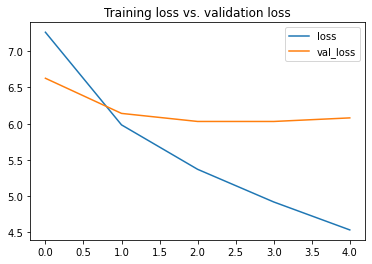

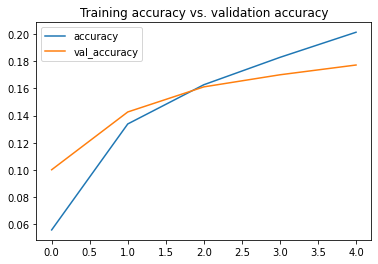

In [35]:
embedding_size = 128

model = models.Sequential()
model.add(layers.Embedding(vocabulary_size,embedding_size,input_length=sequence_length)) #vocsize*embeddingsize=size of the lookup table 
#model.add(layers.LSTM(512))
model.add(layers.GRU(256)) #this is faster but a bit less accurate than LSTM
model.add(layers.Dense(vocabulary_size,activation="softmax")) #we are predicting a word in the vocabulary, so we need a probability distribution across the vocabulary
model.summary()

model.compile(
    optimizer = 'adam',
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

history = model.fit(
    dataset_train.cache().shuffle(90000).batch(512),
    validation_data = dataset_valid.cache().batch(512),
    epochs = 5
)
render_history(history)

In [ ]:
history = model.fit(
    dataset_train.cache().shuffle(90000).batch(512),
    validation_data = dataset_valid.cache().batch(512),
    epochs = 3
)
render_history(history)

In [58]:
# Save the entire model as a SavedModel.
#from google.colab import drive
#drive.mount('/content/gdrive')
#model_save_path ='saved_models/Dostoyevski_GRU_221028' 

#!mkdir -p saved_models
#model.save(model_save_path)

!cp -r saved_models '/content/gdrive/My Drive/'


In [61]:
#Load previously saved model

#drive.mount('/content/gdrive')
model_save_path ='saved_models2/Dostoyevski_GRU_221028' 

#!mkdir -p saved_models2
#!cp -r "/content/gdrive/My Drive/$model_save_path" saved_models2/


model2 = tf.keras.models.load_model(model_save_path)

# Check its architecture
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 32, 128)           5171840   
                                                                 
 gru_1 (GRU)                 (None, 256)               296448    
                                                                 
 dense_2 (Dense)             (None, 40405)             10384085  
                                                                 
Total params: 15,852,373
Trainable params: 15,852,373
Non-trainable params: 0
_________________________________________________________________


TypeError: ignored

In [64]:
import numpy as np
def decode(indices):
    return " ".join([vocabulary[index] for index in indices if vocabulary[index] is not ""])
def generate(model, seed_text, generated_sequence_length, temperature):

    input_sequence = encoder(seed_text).numpy()

    generated_sequence = list(input_sequence[::])

    # Pad.
    padding = [0] * (sequence_length - len(input_sequence))
    input_sequence = padding + list(input_sequence)

    # Generate the sequence by repeatedly predicting.
    while len(generated_sequence) < generated_sequence_length:
        prediction = model.predict(np.expand_dims(input_sequence, axis=0))
        predicted_index = get_index_from_prediction(prediction[0], temperature)
        generated_sequence.append(predicted_index)
        input_sequence = input_sequence[1:]
        input_sequence.append(predicted_index)

    # Convert the generated sequence to a string.
    text = decode(generated_sequence)
    print(text)
    print("")

        
def get_index_from_prediction(prediction, temperature=0.0):
    """ Gets an index from a prediction. """

    # Zero temperature - use the argmax.
    if temperature == 0.0:
        return np.argmax(prediction)

    # Non-zero temperature - do some random magic.
    else:
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature
        exp_prediction= np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction)
        probabilities = np.random.multinomial(1, prediction, 1)
        return np.argmax(probabilities)
  
generate(model2, "He could not believe what he saw.", 100, temperature=1.0)

1/1 [==============================] - 0s 27ms/step
he could not believe what he saw. did he exclaim it ground he sat to look again. but the man had found beating; he would hardly endure the murderer. he sank back quickly and accidentally, as the murderer. when alyosha told another he remembers it all too clearly, for the signals the arrangement in the evening and seemed to touch the bread a glass of the house, and there was the little bag in the work for, while it were come in. and so that he did not burn grushenka. “the sense is worth what some, since that person?” it

